In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_curve
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd

2024-07-12 14:43:46.000907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 14:43:46.001058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 14:43:46.117895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import cv2
from tqdm import tqdm

# Function to load images from a folder and assign all labels as 0
def load_images_from_folder(folder_path):
    images = []
    labels = []
    # Get total number of files for progress bar
    total_files = sum([len(files) for _, _, files in os.walk(folder_path)])
    print(f"Total files found: {total_files}")

    # Check if the folder path exists
    if not os.path.exists(folder_path):
        print(f"Folder path {folder_path} does not exist.")
        return images, labels

    # Load images and resize them
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading images", total=total_files):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(0)
            else:
                print(f"Failed to read image: {img_path}")
        else:
            print(f"{img_path} is not a file, skipping.")

    return images, labels

# Load images from the specified folder
images_folder_path = '/kaggle/input/lag-dataset/non_glaucoma/image'
images, labels = load_images_from_folder(images_folder_path)

Total files found: 3143


Loading images: 100%|██████████| 3143/3143 [00:37<00:00, 82.75it/s]


In [3]:
import os
import cv2
from tqdm import tqdm

# Function to load images from a folder and assign all labels as 1
def load_images_from_folder(folder_path):
    
    # Get total number of files for progress bar
    total_files = sum([len(files) for _, _, files in os.walk(folder_path)])
    print(f"Total files found: {total_files}")

    # Check if the folder path exists
    if not os.path.exists(folder_path):
        print(f"Folder path {folder_path} does not exist.")
        return images, labels

    # Load images and resize them
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading images", total=total_files):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(1)
            else:
                print(f"Failed to read image: {img_path}")
        else:
            print(f"{img_path} is not a file, skipping.")

    return images, labels

# Load images from the specified folder
images_folder_path = '/kaggle/input/lag-dataset/suspicious_glaucoma/image'
images, labels = load_images_from_folder(images_folder_path)

Total files found: 1711


Loading images: 100%|██████████| 1711/1711 [00:19<00:00, 86.26it/s]


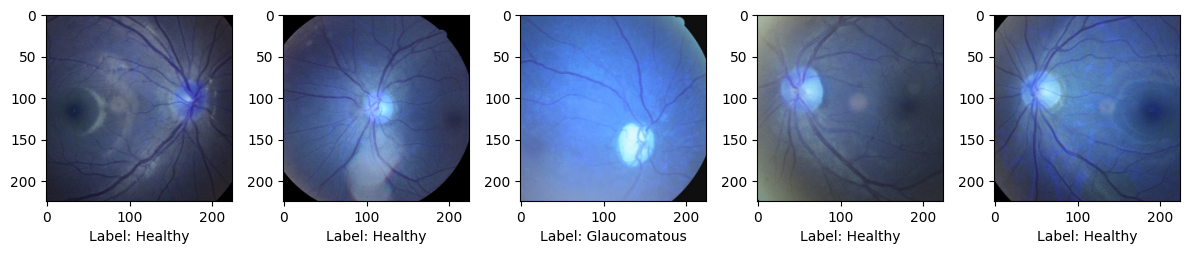

In [4]:
def plot_images(images, labels):
  plt.figure(figsize=(12,7))
  for i in range(5):
      sample = random.choice(range(len(images)))
      image = images[sample]
      categ = labels[sample]

      label = "Glaucomatous" if categ==1 else "Healthy"

      plt.subplot(2, 5, i + 1)
      plt.imshow(image)
      plt.xlabel(f"Label: {label}")

  plt.tight_layout()
  plt.show()

plot_images(images, labels)

Applying blur threshold: 100%|██████████| 4854/4854 [00:00<00:00, 17594.93it/s]


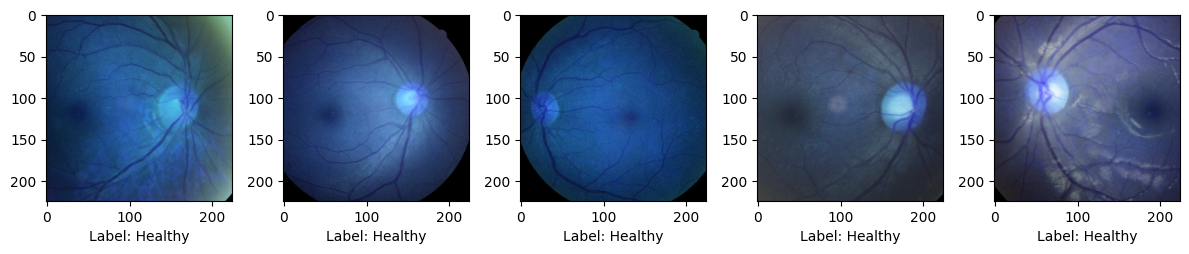

In [5]:
def apply_laplacian_method(image):
    img = cv2.resize(image, (14, 14))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.Laplacian(gray, cv2.CV_64F).var()
    return blur

def apply_laplacian_threshold(images, labels, threshold):
    filtered_images = []
    filtered_labels = []

    for i in tqdm(range(len(images)), desc="Applying blur threshold"):
        blur = apply_laplacian_method(images[i])
        if blur > threshold:
            filtered_images.append(images[i])
            filtered_labels.append(labels[i])

    return np.array(filtered_images), np.array(filtered_labels)

threshold=50
filtered_images, filtered_labels = apply_laplacian_threshold(images, labels, threshold)
plot_images(filtered_images, filtered_labels,)

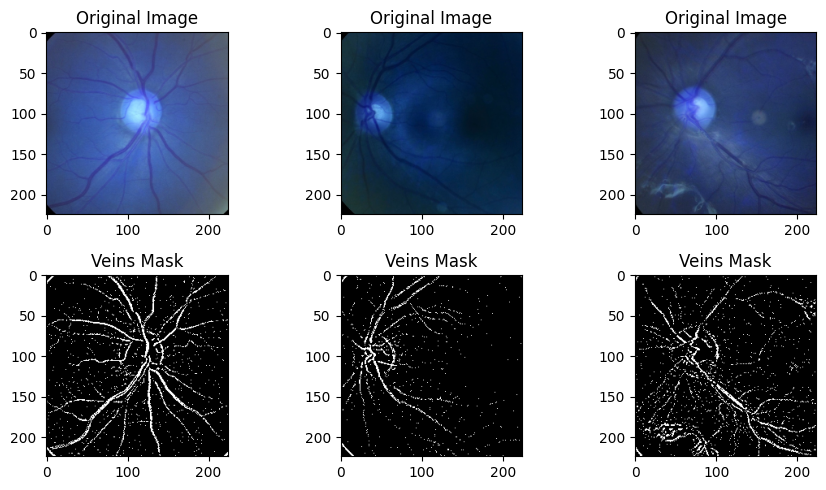

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk, binary_erosion, binary_dilation

def preprocess_image(image_path):
  masks=[]
  preprocessed_images=[]

  for img in image_path:
    # Read the image
    img_color = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    img_blur = cv2.GaussianBlur(img, (3, 3), 0)

    # Enhance veins using a high-pass filter (Laplacian)
    laplacian = cv2.Laplacian(img_blur, cv2.CV_64F)

    # Threshold the image to capture veins
    _, veins_mask = cv2.threshold(laplacian, 3, 255, cv2.THRESH_BINARY)

     # Convert veins mask to binary (0 and 1)
    binary_veins_mask = (veins_mask / 255).astype(np.uint8)

    # Apply morphological operations to remove single dots
    kernel = np.ones((1, 1), np.uint8)
    binary_veins_mask = cv2.morphologyEx(binary_veins_mask, cv2.MORPH_CLOSE, kernel)
    masks.append(binary_veins_mask)

    veins_mask_rgb = np.stack([binary_veins_mask] * 3, axis=-1)

    # Overlay veins mask on the original image
    preprocessed_image = img_color.copy()
    preprocessed_image[veins_mask_rgb == 1] = 255

    preprocessed_images.append(preprocessed_image)

  return np.array(masks), np.array(preprocessed_images)


def plot_images_masks(images, veins_mask, preprocessed_images, labels):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        sample = random.choice(range(len(images)))
        image = images[sample]
        mask = veins_mask[sample]
        pre_image = preprocessed_images[sample]
        category = labels[sample]

        label = 'Glaucomatous' if category == 1 else 'Healthy'

        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')

        plt.subplot(2, 5, i + 6)
        plt.imshow(mask, cmap='gray')
        plt.title('Veins Mask')

    plt.tight_layout()
    plt.show()


image_path = filtered_images
label= filtered_labels

veins_mask, preprocessed_images = preprocess_image(image_path)
plot_images_masks(filtered_images, veins_mask, preprocessed_images, filtered_labels)

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import cv2
from tqdm import tqdm

# Load VGG19 model pretrained on ImageNet
base_model = VGG19(weights='imagenet', include_top=False)

# Create a new model that outputs the features from an intermediate layer
layer_name = 'block5_pool'  # You can choose any layer
intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

# Function to preprocess and load images
def preprocess_image(img_array, target_size=(224, 224)):
    img = cv2.resize(img_array, target_size)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Function to extract features from a list of image arrays
def extract_features_from_images(image_arrays):
    features = []
    for img_array in tqdm(image_arrays, desc="Extracting features"):
        img_preprocessed = preprocess_image(img_array)
        feature = intermediate_layer_model.predict(img_preprocessed, verbose=0)
        features.append(feature.squeeze())
    return np.array(features)

# Example usage
# Assuming `filtered_images` is a list of image arrays loaded into memory
# filtered_images = [cv2.imread(path) for path in image_paths]

# Extract features from the list of image arrays
features = extract_features_from_images(filtered_images)

# Print the shape of the extracted features
print("Shape of extracted features:", features.shape)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting features:   0%|          | 0/4854 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1720795517.117667      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting features: 100%|██████████| 4854/4854 [06:03<00:00, 13.34it/s]


Shape of extracted features: (4854, 7, 7, 512)


In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, accuracy_score, recall_score
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(features, filtered_labels, test_size=0.2, random_state=42)

# Create the binary classification model
model = Sequential([
    Flatten(input_shape=features.shape[1:]),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


checkpoint_path = '/kaggle/working/model.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32, callbacks=[model_checkpoint])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val)
print('Validation accuracy:', val_acc)

# Predict the labels for the validation set
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Print accuracy and recall
val_acc = accuracy_score(y_val, y_pred)
val_recall = recall_score(y_val, y_pred)

print(f'Validation Accuracy: {val_acc}')
print(f'Validation Recall: {val_recall}')

# Generate and print classification report
report = classification_report(y_val, y_pred, target_names=['Non-Glaucoma', 'Glaucoma'])
print(report)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
 21/122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6995 - loss: 2.0031

W0000 00:00:1720795886.692032      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7842 - loss: 1.7345

W0000 00:00:1720795893.653796      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720795894.521556      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.89598, saving model to /kaggle/working/model.keras


W0000 00:00:1720795894.972463      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/122 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.7846 - loss: 1.7329 - val_accuracy: 0.8960 - val_loss: 1.3072
Epoch 2/20
118/122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9301 - loss: 1.1682
Epoch 2: val_accuracy improved from 0.89598 to 0.92791, saving model to /kaggle/working/model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9300 - loss: 1.1665 - val_accuracy: 0.9279 - val_loss: 1.0305
Epoch 3/20
118/122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9562 - loss: 0.9316
Epoch 3: val_accuracy did not improve from 0.92791
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9560 - loss: 0.9308 - val_accuracy: 0.9063 - val_loss: 1.0232
Epoch 4/20
120/122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9548 - loss: 0.8544
Epoch 4: val_accuracy did not improve from 0.92791
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9549 - loss: 0.8538 - val_accuracy: 0.9125 - val_loss: 0.9151
Epoch 5/20
120/122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.962

W0000 00:00:1720795921.851399      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Validation Accuracy: 0.9268795056642637
Validation Recall: 0.8347826086956521
              precision    recall  f1-score   support

Non-Glaucoma       0.91      0.98      0.95       626
    Glaucoma       0.95      0.83      0.89       345

    accuracy                           0.93       971
   macro avg       0.93      0.91      0.92       971
weighted avg       0.93      0.93      0.93       971



W0000 00:00:1720795922.216228      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


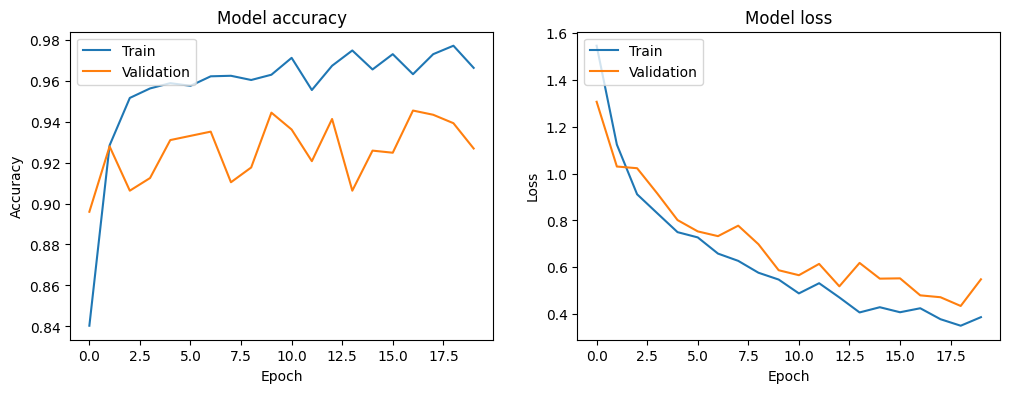

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


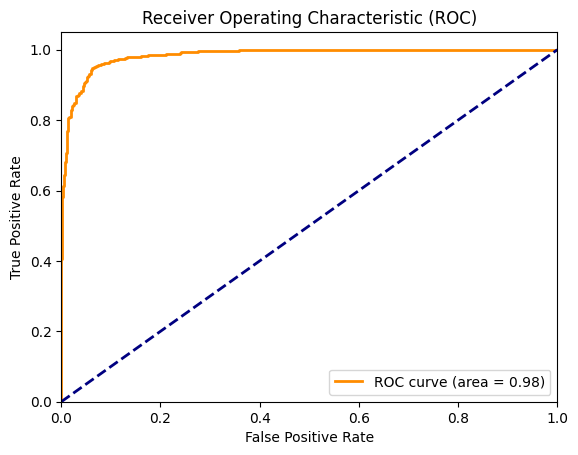

In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Predictions for ROC curve and confusion matrix
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

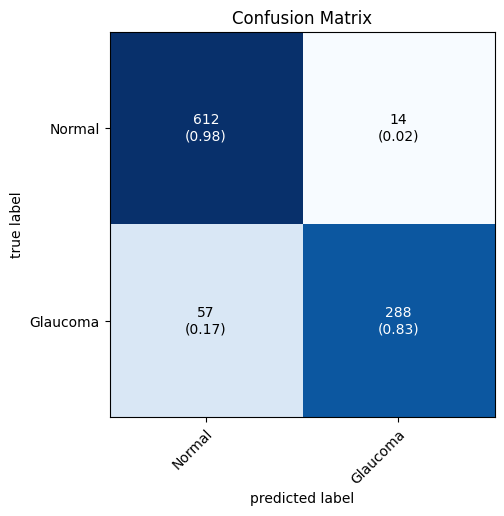

In [11]:
# Confusion Matrix
def plot_conf_matrix(labels, preds):
  cm = confusion_matrix(labels, preds)
  plot_confusion_matrix(conf_mat=cm, figsize=(6, 5), class_names=["Normal", "Glaucoma"], show_normed=True)
  plt.title("Confusion Matrix")
  plt.show()
plot_conf_matrix(y_val, y_pred)

Extracting features: 100%|██████████| 4854/4854 [06:02<00:00, 13.38it/s]


 65/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1720796316.271621      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 98.50%
              precision    recall  f1-score   support

Non-Glaucoma       0.99      0.99      0.99      3143
    Glaucoma       0.98      0.98      0.98      1711

    accuracy                           0.98      4854
   macro avg       0.98      0.98      0.98      4854
weighted avg       0.98      0.98      0.98      4854



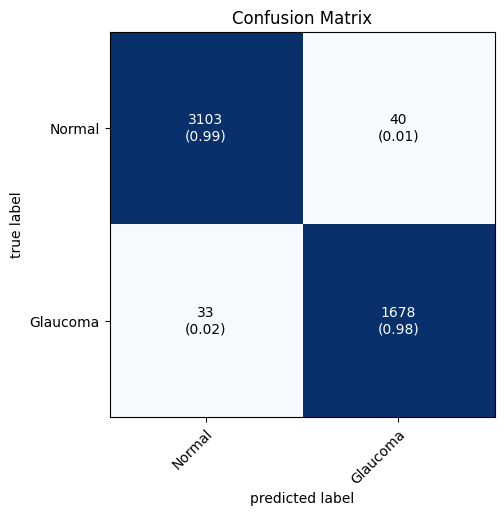

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import cv2
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load VGG19 model pretrained on ImageNet
base_model = VGG19(weights='imagenet', include_top=False)

# Create a new model that outputs the features from an intermediate layer
layer_name = 'block5_pool'  # You can choose any layer
intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

# Function to preprocess and load images
def preprocess_image(img_array, target_size=(224, 224)):
    img = cv2.resize(img_array, target_size)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Function to extract features from a list of image arrays
def extract_features_from_images(image_arrays):
    features = []
    for img_array in tqdm(image_arrays, desc="Extracting features"):
        img_preprocessed = preprocess_image(img_array)
        feature = intermediate_layer_model.predict(img_preprocessed, verbose=0)
        features.append(feature.squeeze())
    return np.array(features)

# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more image formats if needed
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            images.append(image)
            filenames.append(filename)
    return images, filenames

# Function to make predictions on a list of image arrays
def predict_images(model, image_arrays):
    features = extract_features_from_images(image_arrays)
    predictions = model.predict(features)
    return predictions

# Load the trained model with the best weights
checkpoint_path = '/kaggle/working/model.keras'  # Update this path with your model file location
loaded_model = load_model(checkpoint_path)

# Specify the folder paths containing the images
glaucoma_folder_path = '/kaggle/input/lag-dataset/suspicious_glaucoma/image'  # Update this path with your glaucoma image folder location
non_glaucoma_folder_path = '/kaggle/input/lag-dataset/non_glaucoma/image'  # Update this path with your non-glaucoma image folder location

# Load images from both folders
glaucoma_images, glaucoma_filenames = load_images_from_folder(glaucoma_folder_path)
non_glaucoma_images, non_glaucoma_filenames = load_images_from_folder(non_glaucoma_folder_path)

# Combine images and create labels
all_images = glaucoma_images + non_glaucoma_images
all_labels = [1] * len(glaucoma_images) + [0] * len(non_glaucoma_images)

# Make predictions on the combined images
predictions = predict_images(loaded_model, all_images)

# Post-process predictions to get binary class labels
predicted_labels = (predictions > 0.5).astype("int32")

# Calculate accuracy
accuracy = accuracy_score(all_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate and print classification report
report = classification_report(all_labels, predicted_labels, target_names=['Non-Glaucoma', 'Glaucoma'])
print(report)

# Generate and print confusion matrix
plot_conf_matrix(all_labels, predicted_labels)

Extracting features: 100%|██████████| 1041/1041 [01:18<00:00, 13.18it/s]


23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

W0000 00:00:1720796414.477212      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Accuracy: 71.09%
              precision    recall  f1-score   support

Non-Glaucoma       0.72      0.97      0.83       757
    Glaucoma       0.19      0.02      0.03       284

    accuracy                           0.71      1041
   macro avg       0.46      0.49      0.43      1041
weighted avg       0.58      0.71      0.61      1041



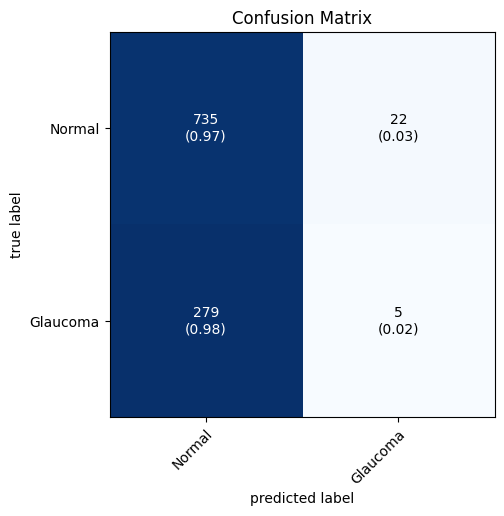

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import cv2
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load VGG19 model pretrained on ImageNet
base_model = VGG19(weights='imagenet', include_top=False)

# Create a new model that outputs the features from an intermediate layer
layer_name = 'block5_pool'  # You can choose any layer
intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

# Function to preprocess and load images
def preprocess_image(img_array, target_size=(224, 224)):
    img = cv2.resize(img_array, target_size)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Function to extract features from a list of image arrays
def extract_features_from_images(image_arrays):
    features = []
    for img_array in tqdm(image_arrays, desc="Extracting features"):
        img_preprocessed = preprocess_image(img_array)
        feature = intermediate_layer_model.predict(img_preprocessed, verbose=0)
        features.append(feature.squeeze())
    return np.array(features)

# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more image formats if needed
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            images.append(image)
            filenames.append(filename)
    return images, filenames

# Function to make predictions on a list of image arrays
def predict_images(model, image_arrays):
    features = extract_features_from_images(image_arrays)
    predictions = model.predict(features)
    return predictions

# Load the trained model with the best weights
checkpoint_path = '/kaggle/working/model.keras'  # Update this path with your model file location
loaded_model = load_model(checkpoint_path)

# Specify the folder paths containing the images
glaucoma_folder_path = '/kaggle/input/g1020-final/G1020/glucoma'  # Update this path with your glaucoma image folder location
non_glaucoma_folder_path = '/kaggle/input/g1020-final/G1020/Non-glucoma'  # Update this path with your non-glaucoma image folder location

# Load images from both folders
glaucoma_images, glaucoma_filenames = load_images_from_folder(glaucoma_folder_path)
non_glaucoma_images, non_glaucoma_filenames = load_images_from_folder(non_glaucoma_folder_path)

# Combine images and create labels
all_images = glaucoma_images + non_glaucoma_images
all_labels = [1] * len(glaucoma_images) + [0] * len(non_glaucoma_images)

# Make predictions on the combined images
predictions = predict_images(loaded_model, all_images)

# Post-process predictions to get binary class labels
predicted_labels = (predictions > 0.5).astype("int32")

# Calculate accuracy
accuracy = accuracy_score(all_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate and print classification report
report = classification_report(all_labels, predicted_labels, target_names=['Non-Glaucoma', 'Glaucoma'])
print(report)

# Generate and print confusion matrix
plot_conf_matrix(all_labels, predicted_labels)